# Model Metrics Visualization

This notebook visualizes precision, recall, and F1 scores for labels 0-5 from saved model metrics.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent.parent))
from models.encoder.metrics_helper import (
    aggregate_metrics_by_model,
    sort_aggregated_models,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 5)

# Load and aggregate all metrics
print("Loading and aggregating metrics...")
aggregated_models = aggregate_metrics_by_model()
aggregated_models = sort_aggregated_models(aggregated_models)

print(f"\nFound {len(aggregated_models)} model configurations:")
for i, m in enumerate(aggregated_models):
    splits = [s for s in ["train", "val", "test"] if m.get(s) is not None]
    print(f"  [{i}] {m['model']} (splits: {', '.join(splits) if splits else 'none'})")

Loading and aggregating metrics...

Found 18 model configurations:
  [0] random (splits: train, val, test)
  [1] random_lg (splits: train, val, test)
  [2] ridge_minilm (splits: train, val, test)
  [3] ridge_minilm_lg (splits: train, val, test)
  [4] ridge_mbert (splits: train, val, test)
  [5] ridge_mbert_lg (splits: train, val, test)
  [6] rf_minilm (splits: train, val, test)
  [7] rf_minilm_lg (splits: train, val, test)
  [8] rf_mbert (splits: train, val, test)
  [9] rf_mbert_lg (splits: train, val, test)
  [10] svm_minilm (splits: train, val, test)
  [11] svm_mbert (splits: train, val, test)
  [12] catboost_minilm (splits: train, val, test)
  [13] catboost_minilm_lg (splits: train, val, test)
  [14] catboost_mbert (splits: train, val, test)
  [15] catboost_mbert_lg (splits: train, val, test)
  [16] finetuned-mbert (splits: train, test)
  [17] finetuned-mbert_lg (splits: train, val, test)


## Specific model

In [4]:
from models.encoder.metrics_helper import extract_per_label_metrics

# Select a model index to visualize
MODEL_INDEX = 1 if len(aggregated_models) > 1 else 0
metrics_data = aggregated_models[MODEL_INDEX]

train_df = extract_per_label_metrics(metrics_data, "train")
cv_df = extract_per_label_metrics(metrics_data, "val")
test_df = extract_per_label_metrics(metrics_data, "test")

print(f"Model: {metrics_data['model']}")
print(f"Parameters: {metrics_data['params']}")

Model: random_lg
Parameters: {'small_dataset_weight_multiplier': 200.0}


### Tables

In [5]:
print("=" * 60)
print("TRAIN METRICS")
print("=" * 60)


def _styled_no_index(df):
    """
    Return a Styler that formats columns and hides the row index by CSS.
    This avoids using Styler.hide_index() which may not be available in older pandas.
    """
    fmt = {"Precision": "{:.4f}", "Recall": "{:.4f}", "F1": "{:.4f}", "Support": "{:d}"}
    return df.style.format(fmt).set_table_styles(
        [{"selector": "th.row_heading, th.blank", "props": [("display", "none")]}]
    )


if train_df is not None:
    display(_styled_no_index(train_df))
    if metrics_data.get("train") is not None:
        print(f"Accuracy: {metrics_data['train']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['train']['mse']:.4f}")

print("\n" + "=" * 60)
print("CROSS-VALIDATION METRICS (Averaged Across Folds)")
print("=" * 60)
if cv_df is not None:
    display(_styled_no_index(cv_df))
    if metrics_data.get("val") is not None:
        print(f"Accuracy: {metrics_data['val']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['val']['mse']:.4f}")

print("\n" + "=" * 60)
print("TEST METRICS")
print("=" * 60)
if test_df is not None:
    display(_styled_no_index(test_df))
    if metrics_data.get("test") is not None:
        print(f"Accuracy: {metrics_data['test']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['test']['mse']:.4f}")

TRAIN METRICS


,Label,Precision,Recall,F1,Support
0,0,0.2649,0.2647,0.2648,26513
1,1,0.1566,0.1569,0.1568,15537
2,2,0.0410,0.0414,0.0412,4496
3,3,0.2065,0.2050,0.2057,20774
4,4,0.1803,0.1813,0.1808,18007
5,5,0.1516,0.1517,0.1516,15065


Accuracy: 0.1937
MSE: 6.7288

CROSS-VALIDATION METRICS (Averaged Across Folds)


,Label,Precision,Recall,F1,Support
0,0,0.0626,0.0667,0.0639,73
1,1,0.1286,0.0472,0.0650,42
2,2,0.2377,0.2923,0.2601,68
3,3,0.2413,0.2275,0.2330,79
4,4,0.1850,0.1846,0.1818,65
5,5,0.1283,0.1692,0.1444,65


Accuracy: 0.1734
MSE: 6.0776

TEST METRICS


,Label,Precision,Recall,F1,Support
0,0,0.1690,0.2449,0.2000,49
1,1,0.2093,0.3214,0.2535,28
2,2,0.1429,0.0222,0.0385,45
3,3,0.2553,0.2308,0.2424,52
4,4,0.2453,0.2955,0.2680,44
5,5,0.2439,0.2273,0.2353,44


Accuracy: 0.2176
MSE: 6.3397


In [10]:
# Display per-fold CV metrics if available
if metrics_data.get("val") and "folds" in metrics_data["val"]:
    print("\n" + "=" * 60)
    print("CROSS-VALIDATION METRICS - PER FOLD")
    print("=" * 60)

    folds_data = metrics_data["val"]["folds"]
    n_folds = len(folds_data)

    for fold_idx, fold_metrics in enumerate(folds_data):
        print(f"\n--- Fold {fold_idx + 1}/{n_folds} ---")

        fold_df = pd.DataFrame(
            {
                "Label": range(6),
                "Precision": fold_metrics.get("precision", [])[:6],
                "Recall": fold_metrics.get("recall", [])[:6],
                "F1": fold_metrics.get("f1", [])[:6],
                "Support": fold_metrics.get("support", [])[:6],
            }
        )

        display(_styled_no_index(fold_df))
        print(f"Accuracy: {fold_metrics['accuracy']:.4f}")
        print(f"MSE: {fold_metrics['mse']:.4f}")


CROSS-VALIDATION METRICS - PER FOLD

--- Fold 1/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.2222,0.2667,0.2424,15
1,1,0.0000,0.0000,0.0000,9
2,2,0.2000,0.2857,0.2353,14
3,3,0.2308,0.2000,0.2143,15
4,4,0.3000,0.2308,0.2609,13
5,5,0.0000,0.0000,0.0000,13


Accuracy: 0.1772
MSE: 6.3291

--- Fold 2/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.0000,0.0000,0.0000,14
1,1,0.1429,0.1111,0.1250,9
2,2,0.3125,0.3571,0.3333,14
3,3,0.1667,0.1250,0.1429,16
4,4,0.1333,0.1538,0.1429,13
5,5,0.2273,0.3846,0.2857,13


Accuracy: 0.1899
MSE: 6.4177

--- Fold 3/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.0000,0.0000,0.0000,14
1,1,0.0000,0.0000,0.0000,8
2,2,0.2941,0.3571,0.3226,14
3,3,0.1579,0.1875,0.1714,16
4,4,0.3333,0.3077,0.3200,13
5,5,0.2000,0.2308,0.2143,13


Accuracy: 0.1923
MSE: 5.4615

--- Fold 4/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.0000,0.0000,0.0000,15
1,1,0.0000,0.0000,0.0000,8
2,2,0.1818,0.1538,0.1667,13
3,3,0.3571,0.3125,0.3333,16
4,4,0.0870,0.1538,0.1111,13
5,5,0.0000,0.0000,0.0000,13


Accuracy: 0.1154
MSE: 7.6667

--- Fold 5/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.0909,0.0667,0.0769,15
1,1,0.5000,0.1250,0.2000,8
2,2,0.2000,0.3077,0.2424,13
3,3,0.2941,0.3125,0.3030,16
4,4,0.0714,0.0769,0.0741,13
5,5,0.2143,0.2308,0.2222,13


Accuracy: 0.1923
MSE: 4.5128


### Confusion Matrix

TRAIN SET CONFUSION MATRIX


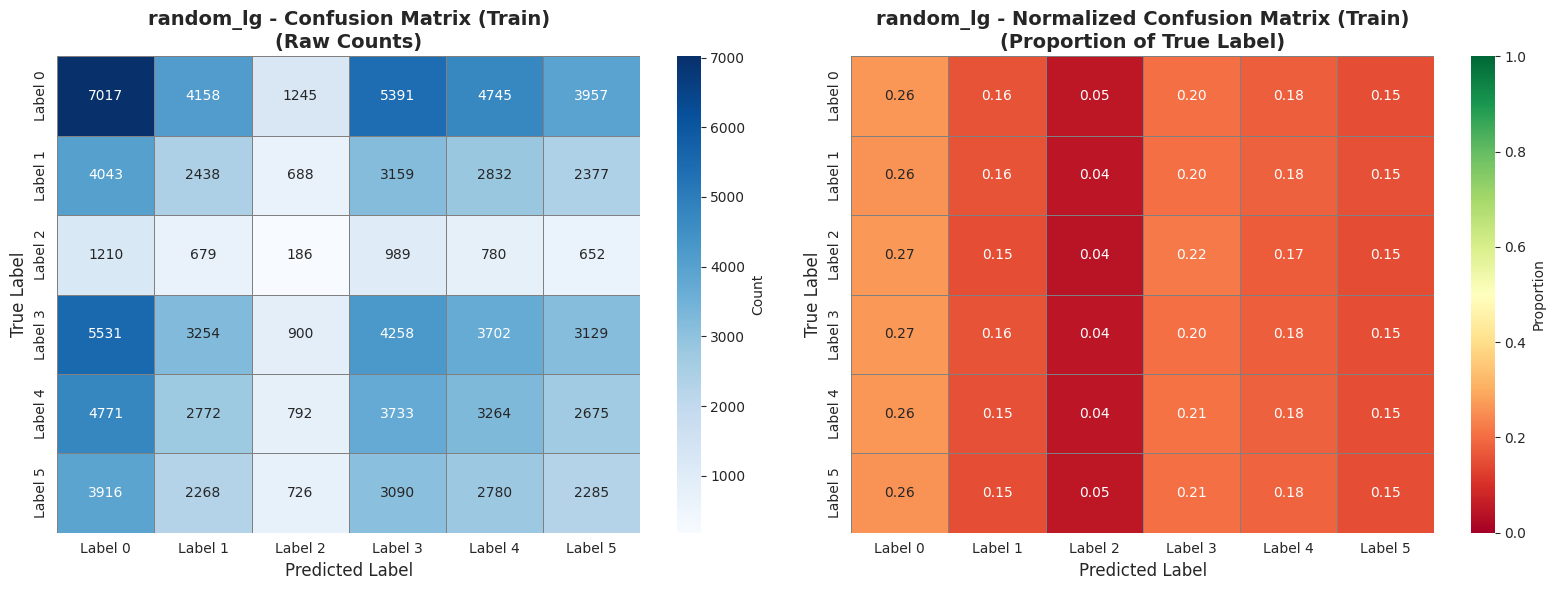


Confusion Matrix Statistics:
  Total predictions: 100392
  Correct predictions (diagonal): 19448
  Incorrect predictions (off-diagonal): 80944
  Accuracy: 0.1937

Per-label statistics:
  Label 0: 7017/26513 correct (26.47%)
  Label 1: 2438/15537 correct (15.69%)
  Label 2: 186/4496 correct (4.14%)
  Label 3: 4258/20774 correct (20.50%)
  Label 4: 3264/18007 correct (18.13%)
  Label 5: 2285/15065 correct (15.17%)

CROSS-VALIDATION CONFUSION MATRIX


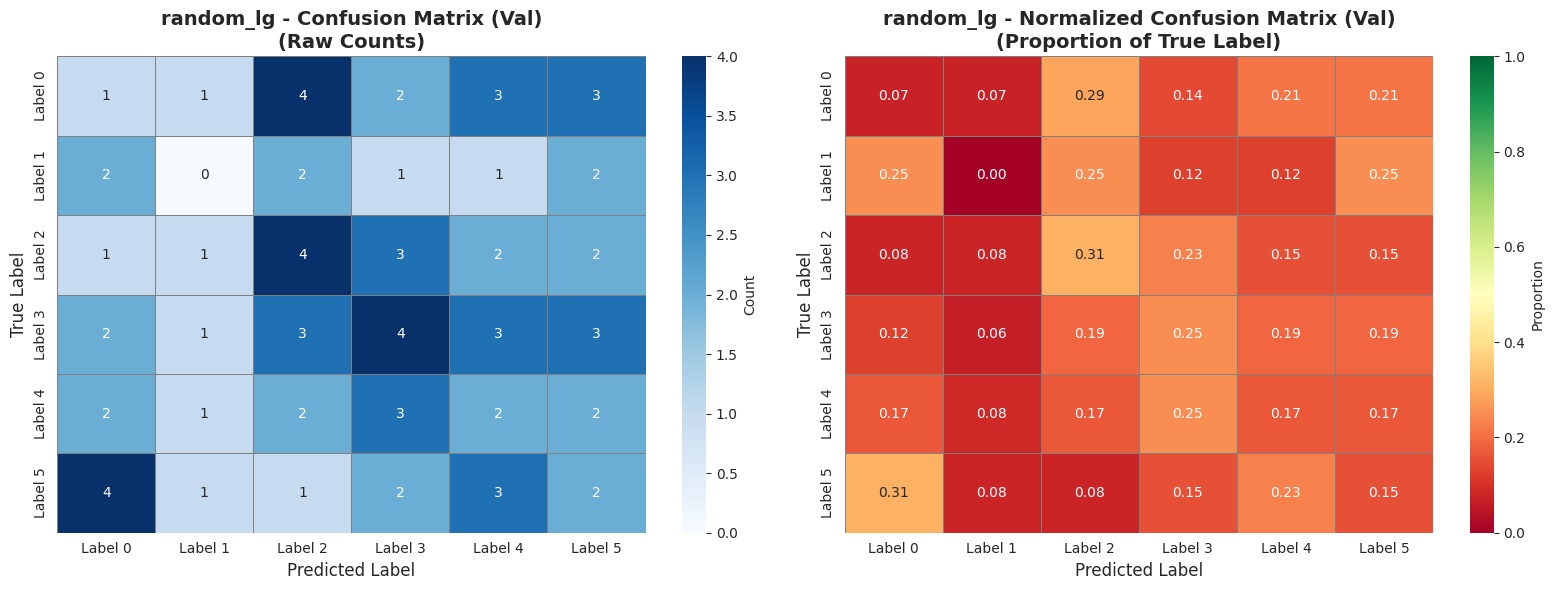


Confusion Matrix Statistics:
  Total predictions: 76
  Correct predictions (diagonal): 13
  Incorrect predictions (off-diagonal): 63
  Accuracy: 0.1711

Per-label statistics:
  Label 0: 1/14 correct (7.14%)
  Label 1: 0/8 correct (0.00%)
  Label 2: 4/13 correct (30.77%)
  Label 3: 4/16 correct (25.00%)
  Label 4: 2/12 correct (16.67%)
  Label 5: 2/13 correct (15.38%)

TEST SET CONFUSION MATRIX


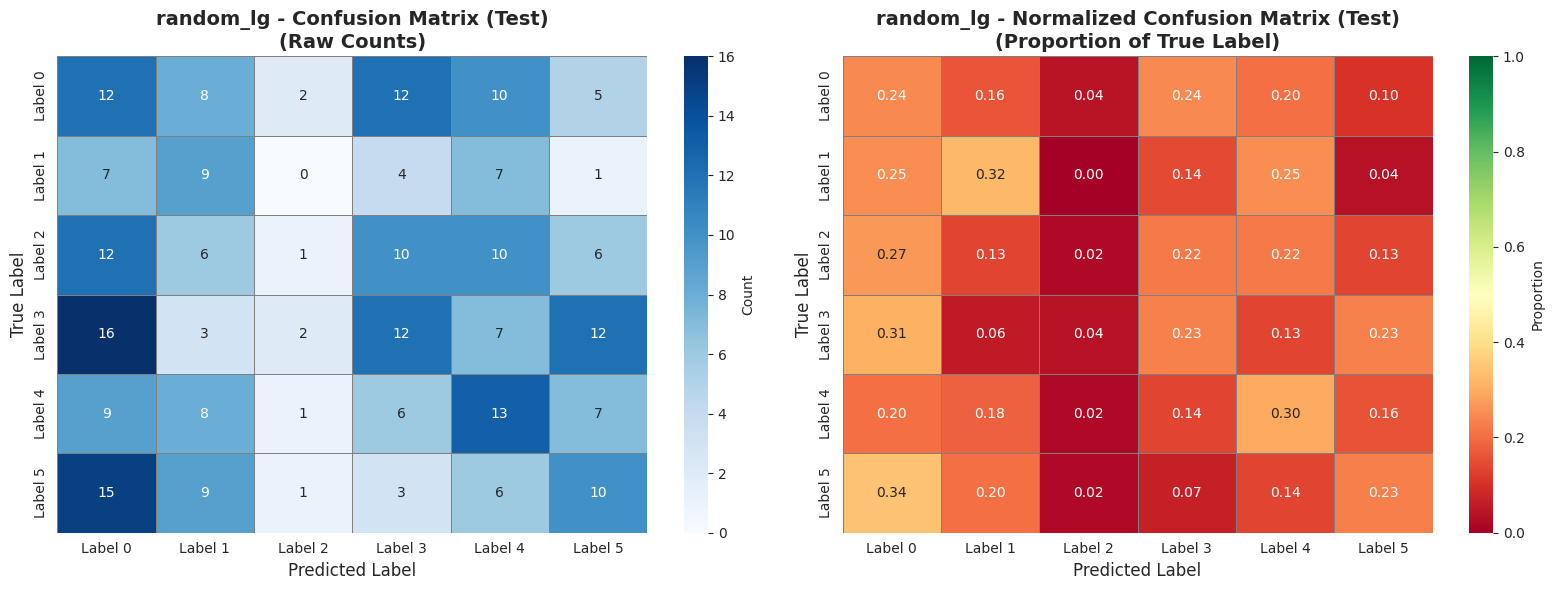


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 57
  Incorrect predictions (off-diagonal): 205
  Accuracy: 0.2176

Per-label statistics:
  Label 0: 12/49 correct (24.49%)
  Label 1: 9/28 correct (32.14%)
  Label 2: 1/45 correct (2.22%)
  Label 3: 12/52 correct (23.08%)
  Label 4: 13/44 correct (29.55%)
  Label 5: 10/44 correct (22.73%)


In [6]:
from models.encoder.metrics_helper import get_confusion_matrix


def plot_confusion_matrix(metrics_dict, dataset="test"):
    """
    Plot confusion matrix showing hits (diagonal) and misses (off-diagonal).

    Args:
        metrics_dict: Dictionary containing model metrics
        dataset: Which dataset to use ('train', 'val', or 'test')
    """
    cm = get_confusion_matrix(metrics_dict, dataset)
    if cm is None:
        print(f"Warning: {dataset} not available for this model")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax1,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Count"},
    )
    ax1.set_title(
        f"{metrics_dict['model']} - Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Raw Counts)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("Predicted Label", fontsize=12)
    ax1.set_ylabel("True Label", fontsize=12)
    ax1.set_xticklabels([f"Label {i}" for i in range(6)])
    ax1.set_yticklabels([f"Label {i}" for i in range(6)])

    # Plot 2: Normalized confusion matrix (by true label)
    cm_normalized = cm.astype("float")
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_normalized = cm_normalized / row_sums

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        ax=ax2,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Proportion"},
        vmin=0,
        vmax=1,
    )
    ax2.set_title(
        f"{metrics_dict['model']} - Normalized Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Proportion of True Label)",
        fontsize=14,
        fontweight="bold",
    )
    ax2.set_xlabel("Predicted Label", fontsize=12)
    ax2.set_ylabel("True Label", fontsize=12)
    ax2.set_xticklabels([f"Label {i}" for i in range(6)])
    ax2.set_yticklabels([f"Label {i}" for i in range(6)])

    plt.tight_layout()
    plt.show()

    total = cm.sum()
    correct = np.trace(cm)
    accuracy = correct / total if total > 0 else 0

    print("\nConfusion Matrix Statistics:")
    print(f"  Total predictions: {total}")
    print(f"  Correct predictions (diagonal): {correct}")
    print(f"  Incorrect predictions (off-diagonal): {total - correct}")
    print(f"  Accuracy: {accuracy:.4f}")
    print("\nPer-label statistics:")
    for i in range(6):
        true_count = cm[i, :].sum()
        correct_count = cm[i, i]
        if true_count > 0:
            per_label_acc = correct_count / true_count
            print(
                f"  Label {i}: {correct_count}/{true_count} correct ({per_label_acc:.2%})"
            )
        else:
            print(f"  Label {i}: No samples")


print("=" * 80)
print("TRAIN SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "train")

print("\n" + "=" * 80)
print("CROSS-VALIDATION CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "val")

print("\n" + "=" * 80)
print("TEST SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "test")

## All models

Comparing all available models...



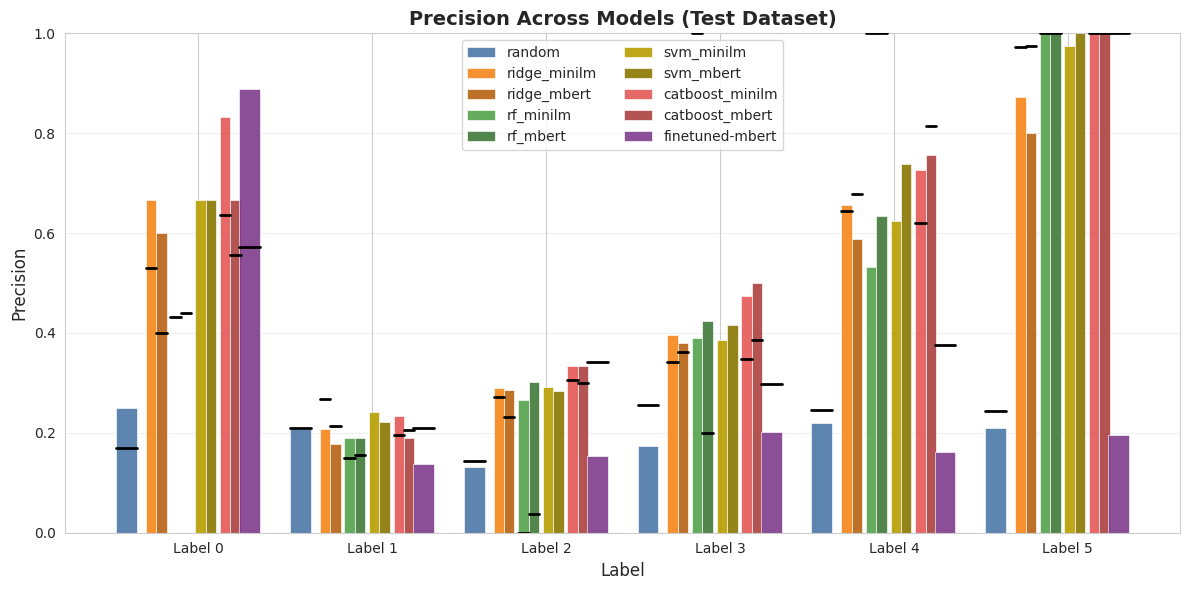

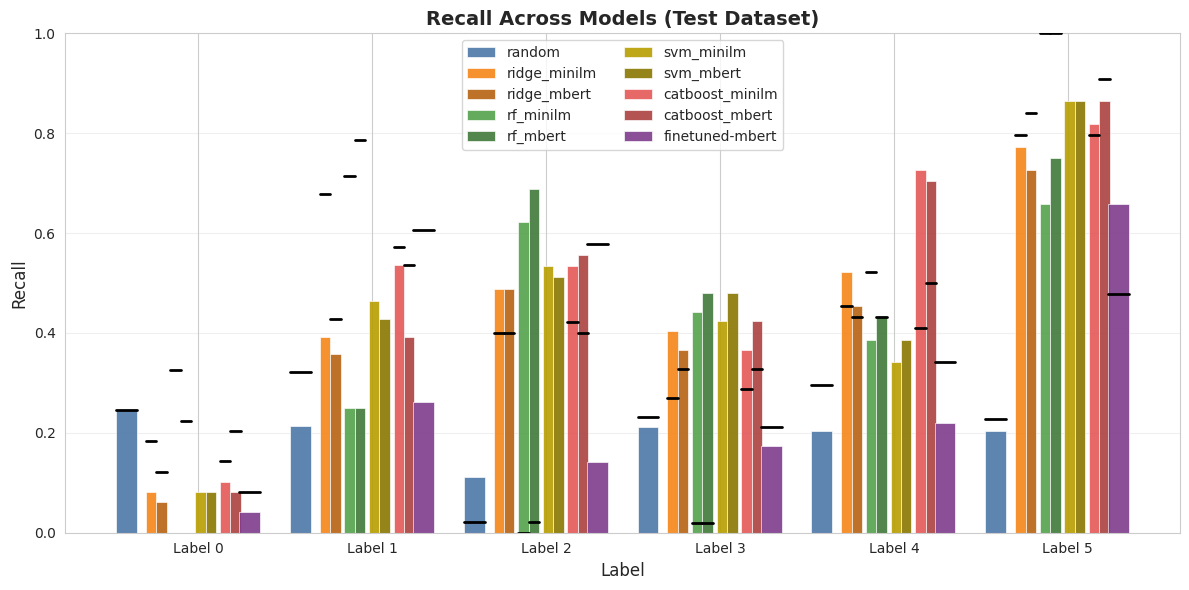

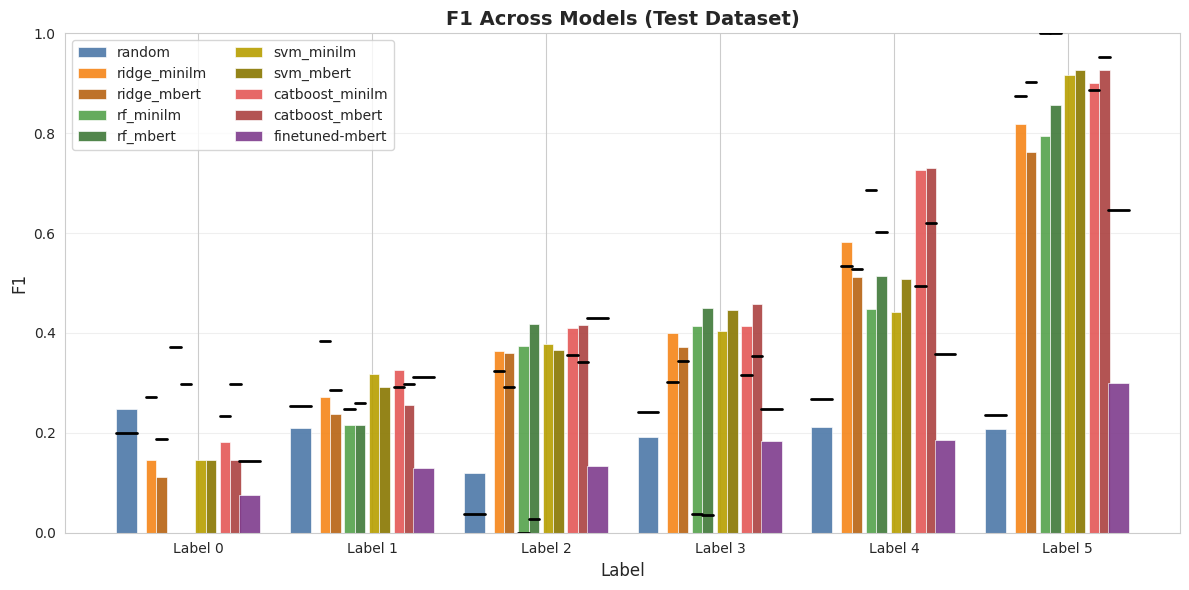

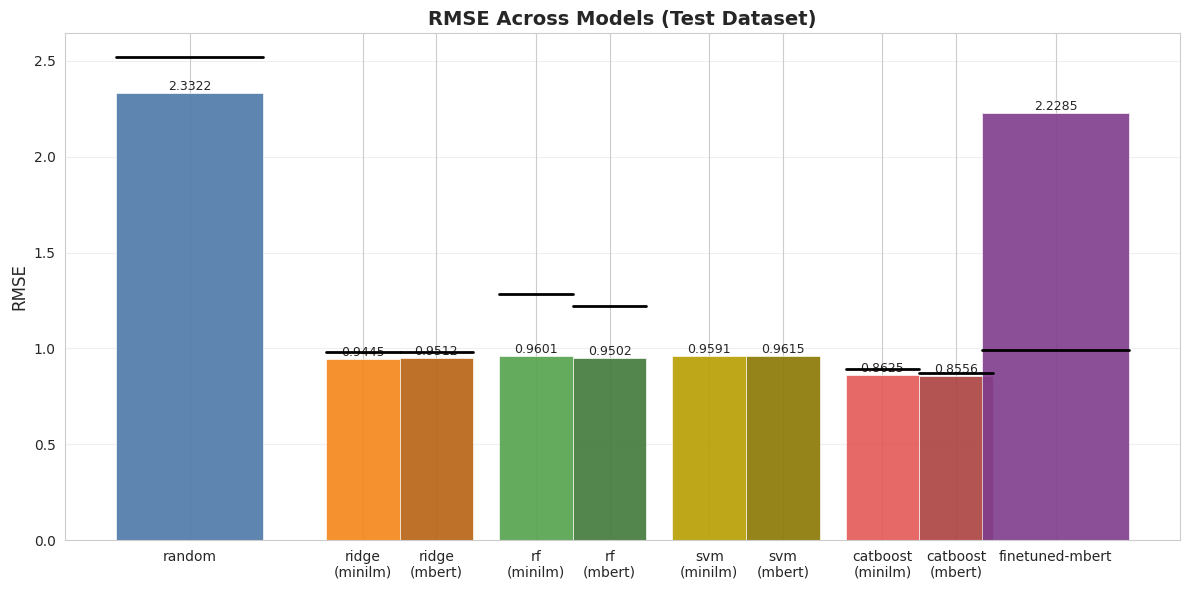

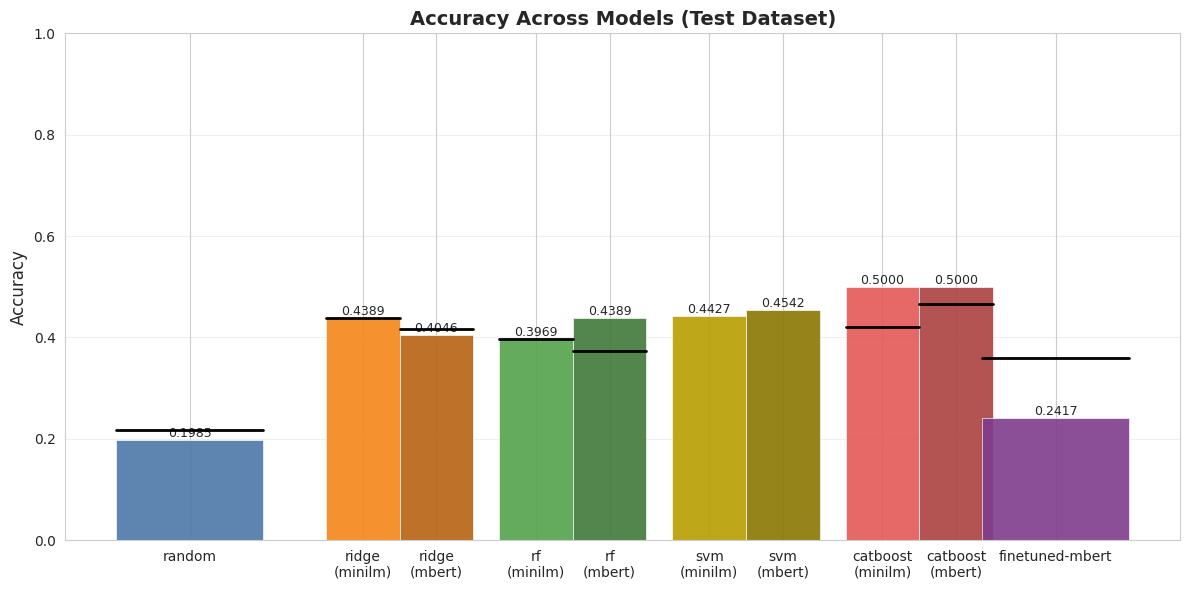

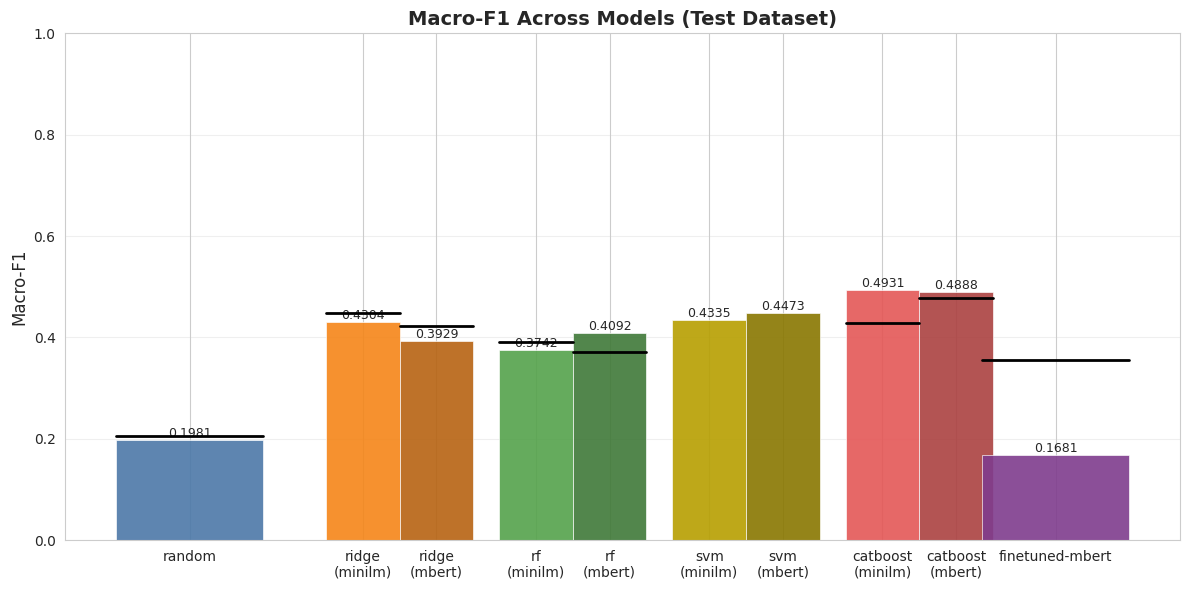

In [7]:
def compare_models(models, dataset="test"):
    """
    Compare per-label metrics across multiple aggregated model dicts.
    """
    models_data = []
    lg_models_data = []
    for m in models:
        if m.get(dataset) is not None:
            if "_lg" in m["model"]:
                lg_models_data.append({"model": m["model"], "metrics": m[dataset]})
            else:
                models_data.append({"model": m["model"], "metrics": m[dataset]})
    if not models_data:
        print(f"No models with {dataset} available")
        return

    # Create a lookup for _lg models by their base name
    lg_lookup = {}
    for lg_md in lg_models_data:
        base_name = lg_md["model"].replace("_lg", "")
        lg_lookup[base_name] = lg_md

    def parse_model(name: str):
        parts = name.split("_")
        if len(parts) >= 2:
            return parts[0], parts[1]
        return parts[0], None

    base_to_models = {}
    for md in models_data:
        base, emb = parse_model(md["model"])
        base_to_models.setdefault(base, []).append((emb, md))

    MODEL_ORDER = ["random", "ridge", "rf", "svm", "catboost", "finetuned-mbert"]
    EMBED_ORDER = ["minilm", "mbert"]

    ordered_bases = [b for b in MODEL_ORDER if b in base_to_models]
    ordered_bases += [b for b in base_to_models.keys() if b not in ordered_bases]

    for base in ordered_bases:
        embeds_present = [emb for emb, _ in base_to_models[base]]
        ordered_embeds = [e for e in EMBED_ORDER if e in embeds_present]
        ordered_embeds += [e for e in embeds_present if e not in ordered_embeds]
        md_map = {emb: md for emb, md in base_to_models[base]}
        base_to_models[base] = [(emb, md_map[emb]) for emb in ordered_embeds]

    base_colors = {
        "random": "#4C78A8",
        "ridge": "#F58518",
        "rf": "#54A24B",
        "svm": "#B79F00",
        "catboost": "#E45756",
        "finetuned": "#7F3C8D",
        "finetuned-mbert": "#7F3C8D",
    }

    def darken(hex_color, factor=0.75):
        hex_color = hex_color.lstrip("#")
        r = int(hex_color[0:2], 16)
        g = int(hex_color[2:4], 16)
        b = int(hex_color[4:6], 16)
        r = int(r * factor)
        g = int(g * factor)
        b = int(b * factor)
        return f"#{r:02x}{g:02x}{b:02x}"

    total_cluster_width = 0.85
    n_bases = len(ordered_bases)
    base_slot_width = total_cluster_width / n_bases if n_bases else 0.0
    base_slot_margin_factor = 0.15

    for metric_name in ["Precision", "Recall", "F1"]:
        fig, ax = plt.subplots(figsize=(12, 6))
        for base_idx, base in enumerate(ordered_bases):
            variants = base_to_models[base]
            n_variants = len(variants)
            inner_width = base_slot_width * (1 - base_slot_margin_factor)
            bar_width = inner_width / n_variants if n_variants else inner_width * 0.5
            base_center_offset = -total_cluster_width / 2 + base_slot_width * (
                base_idx + 0.5
            )
            for v_idx, (emb, md) in enumerate(variants):
                metric_key = metric_name.lower()
                values = md["metrics"].get(metric_key, [])
                values = values + [0.0] * (6 - len(values))
                base_positions = np.arange(6) + base_center_offset
                variant_offset_start = -inner_width / 2 + v_idx * bar_width
                x_positions = base_positions + variant_offset_start
                c = base_colors.get(base, "#888888")
                if emb == "mbert":
                    c = darken(c)
                ax.bar(
                    x_positions,
                    values[:6],
                    width=bar_width,
                    label=md["model"],
                    alpha=0.9,
                    color=c,
                    edgecolor="white",
                    linewidth=0.5,
                )

                # Add horizontal line for _lg variant if exists
                lg_md = lg_lookup.get(md["model"])
                if lg_md is not None:
                    lg_values = lg_md["metrics"].get(metric_key, [])
                    lg_values = lg_values + [0.0] * (6 - len(lg_values))
                    for label_idx in range(6):
                        x_pos = x_positions[label_idx]
                        lg_val = lg_values[label_idx]

                        line_y = lg_val
                        line_left = x_pos - bar_width / 2
                        line_right = x_pos + bar_width / 2

                        ax.plot(
                            [line_left, line_right],
                            [line_y, line_y],
                            color="black",
                            linewidth=2,
                            zorder=10,
                        )

        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(
            f"{metric_name} Across Models ({dataset.replace('_', ' ').title()} Dataset)",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xticks(np.arange(6))
        ax.set_xticklabels([f"Label {i}" for i in range(6)])
        ax.set_ylim(0, 1.0)
        ax.grid(axis="y", alpha=0.3)
        handles, labels = ax.get_legend_handles_labels()
        seen = set()
        new_handles, new_labels = [], []
        for h, label in zip(handles, labels):
            if label not in seen:
                seen.add(label)
                new_handles.append(h)
                new_labels.append(label)
        ax.legend(new_handles, new_labels, fontsize=10, ncol=2)
        plt.tight_layout()
        plt.show()

    flat_models = []
    for base in ordered_bases:
        for emb, md in base_to_models[base]:
            flat_models.append((base, emb, md))

    def build_cluster_positions():
        positions = []
        for base_idx, base in enumerate(ordered_bases):
            variants = [t for t in flat_models if t[0] == base]
            n_variants = len(variants)
            inner_width = base_slot_width * (1 - base_slot_margin_factor)
            bar_width = inner_width / n_variants if n_variants else inner_width * 0.5
            base_center_offset = -total_cluster_width / 2 + base_slot_width * (
                base_idx + 0.5
            )
            for v_idx, (b, emb, md) in enumerate(variants):
                variant_offset_start = -inner_width / 2 + v_idx * bar_width
                pos = base_center_offset + variant_offset_start
                positions.append((b, emb, md, pos, bar_width))
        return positions

    n_bases = len(ordered_bases)
    clustered_positions = build_cluster_positions()
    variant_positions = [pos for _, _, _, pos, _ in clustered_positions]
    variant_labels = []
    for base, emb, md, pos, bw in clustered_positions:
        if emb is None:
            variant_labels.append(f"{base}")
        else:
            variant_labels.append(f"{base}\n({emb})")

    def plot_single_metric(metric_key, title, ylim=None, transform=None, y_label=None):
        fig, ax = plt.subplots(figsize=(12, 6))
        for base, emb, md, pos, bw in clustered_positions:
            val = md["metrics"].get(metric_key)
            if val is None:
                continue
            if transform:
                val = transform(val)
            c = base_colors.get(base, "#888888")
            if emb == "mbert":
                c = darken(c)
            bar = ax.bar(
                [pos],
                [val],
                width=bw,
                color=c,
                alpha=0.9,
                edgecolor="white",
                linewidth=0.5,
            )[0]
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{val:.4f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

            # Add horizontal line for _lg variant if exists
            lg_md = lg_lookup.get(md["model"])
            if lg_md is not None:
                lg_val = lg_md["metrics"].get(metric_key)
                if lg_val is not None:
                    if transform:
                        lg_val = transform(lg_val)
                    line_left = pos - bw / 2
                    line_right = pos + bw / 2
                    ax.plot(
                        [line_left, line_right],
                        [lg_val, lg_val],
                        color="black",
                        linewidth=2,
                        zorder=10,
                    )

        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_ylabel(y_label if y_label else metric_key.title(), fontsize=12)
        ax.grid(axis="y", alpha=0.3)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xticks(variant_positions)
        ax.set_xticklabels(variant_labels, fontsize=10)
        plt.tight_layout()
        plt.show()

    plot_single_metric(
        "mse",
        f"RMSE Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        transform=lambda x: np.sqrt(x),
        y_label="RMSE",
    )
    plot_single_metric(
        "accuracy",
        f"Accuracy Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        ylim=(0, 1.0),
    )

    # Macro-F1
    fig, ax = plt.subplots(figsize=(12, 6))
    for base, emb, md, pos, bw in clustered_positions:
        f1_list = md["metrics"].get("f1", [])
        if not f1_list:
            continue
        macro_f1 = np.mean(f1_list)
        c = base_colors.get(base, "#888888")
        if emb == "mbert":
            c = darken(c)
        bar = ax.bar(
            [pos],
            [macro_f1],
            width=bw,
            color=c,
            alpha=0.9,
            edgecolor="white",
            linewidth=0.5,
        )[0]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{macro_f1:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

        # Add horizontal line for _lg variant if exists
        lg_md = lg_lookup.get(md["model"])
        if lg_md is not None:
            lg_f1_list = lg_md["metrics"].get("f1", [])
            if lg_f1_list:
                lg_macro_f1 = np.mean(lg_f1_list)
                line_left = pos - bw / 2
                line_right = pos + bw / 2
                ax.plot(
                    [line_left, line_right],
                    [lg_macro_f1, lg_macro_f1],
                    color="black",
                    linewidth=2,
                    zorder=10,
                )

    ax.set_title(
        f"Macro-F1 Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylabel("Macro-F1", fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)
    ax.set_xticks(variant_positions)
    ax.set_xticklabels(variant_labels, fontsize=10)
    plt.tight_layout()
    plt.show()


if len(aggregated_models) > 0:
    print("Comparing all available models...\n")
    compare_models(aggregated_models, "test")

In [8]:
all_metrics = []
for m in aggregated_models:

    def _safe(dataset, key):
        d = m.get(dataset)
        if d is None:
            return np.nan
        val = d.get(key)
        return val if val is not None else np.nan

    def _rmse(dataset):
        mse = _safe(dataset, "mse")
        return np.sqrt(mse) if not pd.isna(mse) else np.nan

    def _macro_f1(dataset):
        d = m.get(dataset)
        if d and d.get("f1"):
            return float(np.mean(d["f1"]))
        return np.nan

    all_metrics.append(
        {
            "Model": m["model"],
            "Train RMSE": _rmse("train"),
            "CV RMSE": _rmse("val"),
            "Test RMSE": _rmse("test"),
            "Train Acc": _safe("train", "accuracy"),
            "CV Acc": _safe("val", "accuracy"),
            "Test Acc": _safe("test", "accuracy"),
            "Train Macro-F1": _macro_f1("train"),
            "CV Macro-F1": _macro_f1("val"),
            "Test Macro-F1": _macro_f1("test"),
        }
    )

metrics_df = pd.DataFrame(all_metrics)

display(
    metrics_df.style.format(
        {
            "Train RMSE": "{:.4f}",
            "CV RMSE": "{:.4f}",
            "Test RMSE": "{:.4f}",
            "Train Acc": "{:.4f}",
            "CV Acc": "{:.4f}",
            "Test Acc": "{:.4f}",
            "Train Macro-F1": "{:.4f}",
            "CV Macro-F1": "{:.4f}",
            "Test Macro-F1": "{:.4f}",
        }
    ).set_caption("Model Metrics Comparison")
)

,Model,Train RMSE,CV RMSE,Test RMSE,Train Acc,CV Acc,Test Acc,Train Macro-F1,CV Macro-F1,Test Macro-F1
0,random,2.3129,2.4653,2.3322,0.1760,0.1734,0.1985,0.1762,0.1580,0.1981
1,random_lg,2.5940,2.4653,2.5179,0.1937,0.1734,0.2176,0.1668,0.1580,0.2063
2,ridge_minilm,0.5251,0.9334,0.9445,0.6760,0.4160,0.4389,0.6699,0.4110,0.4304
3,ridge_minilm_lg,0.7297,0.9972,0.9796,0.5951,0.4265,0.4389,0.5797,0.4460,0.4484
4,ridge_mbert,0.5226,0.9282,0.9512,0.6607,0.4159,0.4046,0.6502,0.4062,0.3929
5,ridge_mbert_lg,0.7082,0.9717,0.9799,0.6029,0.4366,0.4160,0.5863,0.4489,0.4233
6,rf_minilm,0.1424,0.9792,0.9601,0.9974,0.4109,0.3969,0.9969,0.3749,0.3742
7,rf_minilm_lg,0.1702,1.3074,1.2820,0.9802,0.3924,0.3969,0.9668,0.3874,0.3906
8,rf_mbert,0.0320,0.9728,0.9502,1.0000,0.4212,0.4389,1.0000,0.3929,0.4092
9,rf_mbert_lg,0.3779,1.3617,1.2211,0.7978,0.3599,0.3740,0.7967,0.3581,0.3704


## Training Curves Visualization

This section visualizes training and validation loss curves for fine-tuning trials.

In [9]:
import matplotlib.cm as cm


def plot_all_folds_for_multiple_cv(cv_data_list):
    """
    Plot training curves for all folds across multiple CV runs in a grid.
    Each CV run will be shown with a different shade of blue (train) and red (val).

    Args:
        cv_data_list: List of dictionaries containing val metrics with 'folds' structure.
    """
    if not cv_data_list:
        print("No CV data provided")
        return

    # Determine the maximum number of folds across all CV runs
    max_folds = max(len(cv_data.get("folds", [])) for cv_data in cv_data_list)

    if max_folds == 0:
        print("No folds found in any CV data")
        return

    # Create subplot grid
    n_cols = min(3, max_folds)
    n_rows = (max_folds + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    if max_folds == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes

    # Generate color palettes for train and val losses
    n_cv_runs = len(cv_data_list)

    # Create blue shades for training and red shades for validation
    train_colors = cm.Blues(np.linspace(0.4, 0.9, n_cv_runs))
    val_colors = cm.Reds(np.linspace(0.4, 0.9, n_cv_runs))

    # Plot each fold across all CV runs
    for fold_idx in range(max_folds):
        ax = axes[fold_idx] if max_folds > 1 else axes[0]

        for cv_idx, cv_data in enumerate(cv_data_list):
            folds = cv_data.get("folds", [])

            # Skip if this CV run doesn't have this fold
            if fold_idx >= len(folds):
                continue

            fold_data = folds[fold_idx]
            label_suffix = cv_data.get("model", f"CV {cv_idx}")

            train_losses = fold_data.get("train_losses", [])
            val_losses = fold_data.get("val_losses", [])

            epochs_train = list(range(1, len(train_losses) + 1))
            epochs_val = list(range(1, len(val_losses) + 1))

            if train_losses:
                ax.plot(
                    epochs_train,
                    train_losses,
                    "-o",
                    color=train_colors[cv_idx],
                    alpha=0.7,
                    linewidth=2,
                    markersize=3,
                    label=f"Train - {label_suffix}",
                )
            if val_losses:
                ax.plot(
                    epochs_val,
                    val_losses,
                    "-o",
                    color=val_colors[cv_idx],
                    linewidth=2,
                    markersize=3,
                    label=f"Val - {label_suffix}",
                )

                # Mark best epoch (lowest val loss)
                if val_losses:
                    best_epoch = int(np.argmin(val_losses))
                    best_val_loss = val_losses[best_epoch]
                    ax.axvline(
                        x=best_epoch + 1,
                        color=val_colors[cv_idx],
                        linestyle="--",
                        alpha=0.3,
                        linewidth=1,
                    )
                    ax.plot(
                        best_epoch + 1,
                        best_val_loss,
                        "*",
                        color=val_colors[cv_idx],
                        markersize=10,
                        zorder=5,
                    )

        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Fold {fold_idx}", fontweight="bold")
        ax.legend(fontsize=8, loc="best")
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(max_folds, len(axes)):
        axes[idx].axis("off")

    # Create title from all model names
    model_names = [cv_data.get("model", "Unknown") for cv_data in cv_data_list]
    if len(set(model_names)) == 1:
        title = f"{model_names[0]} - All Folds ({n_cv_runs} CV runs)"
    else:
        title = f"Cross-Validation Comparison - All Folds ({n_cv_runs} runs)"

    fig.suptitle(title, fontsize=16, fontweight="bold", y=1.00)
    plt.tight_layout()
    plt.show()

### HP Cross-validation

In [10]:
from models.encoder.metrics_helper import load_cv_history_files

# Find val (cross-validation) metric files with training curves
cv_history_files = load_cv_history_files()
print(f"Found {len(cv_history_files)} val metric files:")
for f in cv_history_files[:10]:  # Show first 10
    print(f"  - {f.name}")
if len(cv_history_files) > 10:
    print(f"  ... and {len(cv_history_files) - 10} more")

Found 23 val metric files:
  - catboost_mbert_lg_val_42_2025-11-23-10-53-22.json
  - catboost_mbert_lg_val_42_2025-12-03-19-09-14.json
  - catboost_mbert_val_42_2025-12-03-19-03-46.json
  - catboost_minilm_lg_val_42_2025-11-22-14-33-39.json
  - catboost_minilm_lg_val_42_2025-12-03-21-03-19.json
  - catboost_minilm_val_42_2025-12-03-19-00-43.json
  - finetuned-mbert_lg_val_42_2025-11-30-22-16-11.json
  - random_lg_val_42_2025-12-03-21-03-09.json
  - random_val_42_2025-12-03-19-00-43.json
  - rf_mbert_lg_val_42_2025-11-23-09-21-56.json
  ... and 13 more


Loading val metrics from: finetuned-mbert_lg_val_42_2025-11-30-22-16-11.json

Plotting 1 CV run(s)...



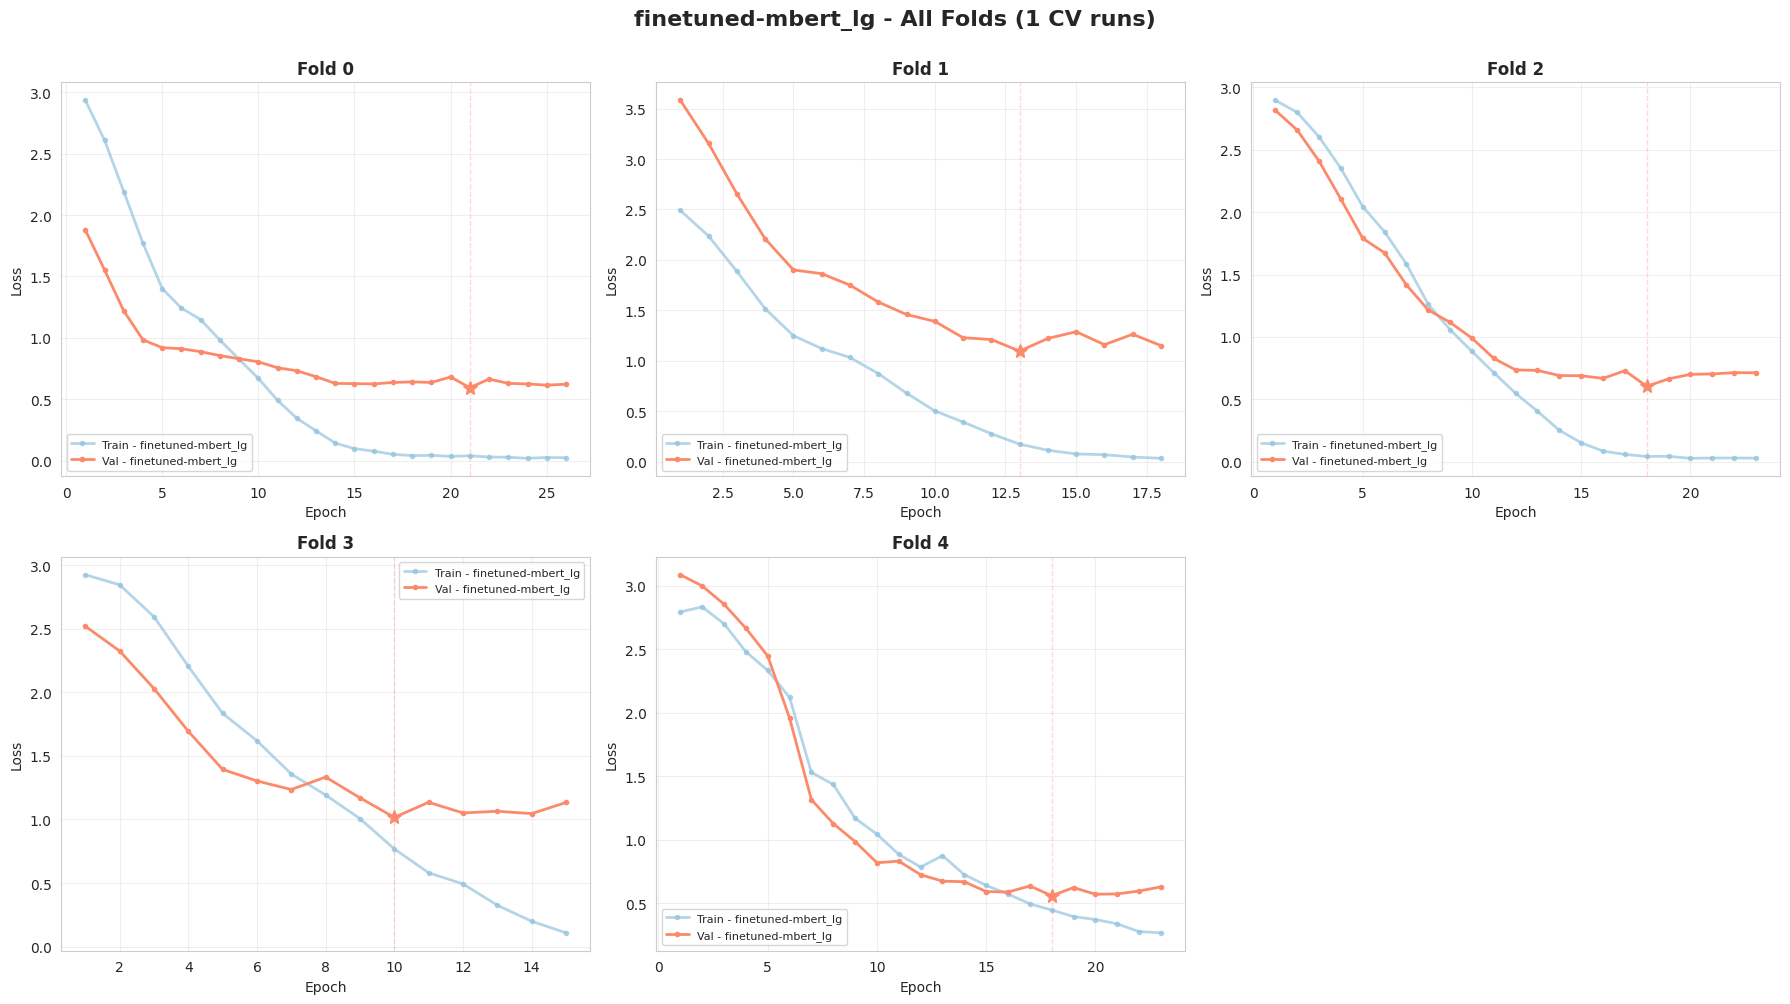

In [12]:
from models.encoder.metrics_helper import load_cv_data

# Select which CV files to visualize (can select multiple)
if cv_history_files:
    # Specify indices of files to compare
    CV_FILE_INDICES = [6]  # Modify this list to select specific files

    cv_data_list = []

    for idx in CV_FILE_INDICES:
        if idx < len(cv_history_files):
            selected_file = cv_history_files[idx]

            print(f"Loading val metrics from: {selected_file.name}")

            cv_data = load_cv_data(selected_file)
            if cv_data is None:
                print(f"Warning: {selected_file.name} has no folds data")
                continue

            cv_data_list.append(cv_data)

    if cv_data_list:
        print(f"\nPlotting {len(cv_data_list)} CV run(s)...\n")
        plot_all_folds_for_multiple_cv(cv_data_list)
    else:
        print("No valid CV data to plot!")
else:
    print("No CV metric files found!")

### Train+Val

In [15]:
from models.encoder.metrics_helper import load_train_history_files

# Find train metric files with training curves
train_history_files = load_train_history_files()
print(f"Found {len(train_history_files)} train metric files:")
for f in train_history_files[:10]:  # Show first 10
    print(f"  - {f.name}")
if len(train_history_files) > 10:
    print(f"  ... and {len(train_history_files) - 10} more")

Found 20 train metric files:
  - catboost_mbert_lg_train_42_2025-11-23-10-41-49.json
  - catboost_mbert_train_42_2025-11-21-22-28-36.json
  - catboost_minilm_lg_train_42_2025-11-22-14-33-39.json
  - catboost_minilm_train_42_2025-11-21-22-25-05.json
  - finetuned-mbert_lg_train_42_2025-11-30-21-20-40.json
  - finetuned-mbert_train_40_2025-11-26-17-47-05.json
  - finetuned-mbert_train_41_2025-11-26-17-49-15.json
  - finetuned-mbert_train_42_2025-11-26-17-51-22.json
  - random_lg_train_42_2025-11-21-22-54-35.json
  - random_train_42_2025-11-21-22-28-21.json
  ... and 10 more


Loading training metrics from: finetuned-mbert_lg_train_42_2025-11-30-21-20-40.json
  Model: finetuned-mbert_lg, Train batches: 126, Val epochs: 0, Batch size: None, Batches/epoch: 1


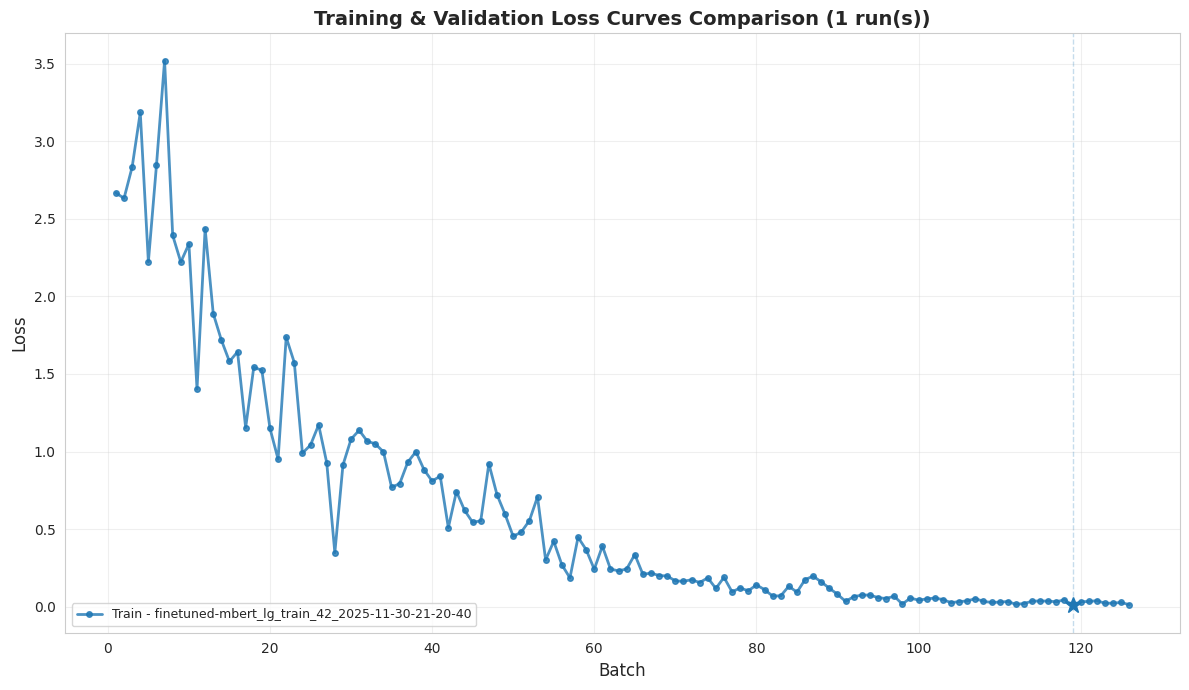


Plotted 1 training run(s)


In [17]:
from models.encoder.metrics_helper import load_train_data


# Select which training files to visualize and plot them together
if train_history_files:
    TRAIN_FILE_INDICES = [4]  # Modify to select specific files

    fig, ax = plt.subplots(figsize=(12, 7))

    n_files = len(TRAIN_FILE_INDICES)
    colors = cm.tab10(np.linspace(0, 1, min(n_files, 10)))

    for idx, file_idx in enumerate(TRAIN_FILE_INDICES):
        if file_idx >= len(train_history_files):
            continue
        selected_file = train_history_files[file_idx]

        print(f"Loading training metrics from: {selected_file.name}")
        data = load_train_data(selected_file)
        if data is None:
            print(f"Warning: {selected_file.name} has no training losses")
            continue

        model_name = data.get("model", selected_file.stem)
        train_losses = data.get("train_losses", [])
        val_losses = data.get("val_losses", [])
        params = data.get("params", {})
        batch_size = params.get("batch_size", None)
        n_train_samples = params.get("n_train_samples", None)
        n_epochs = len(val_losses) if val_losses else None

        color = colors[idx % len(colors)]

        # Calculate batches_per_epoch
        if batch_size and n_train_samples:
            batches_per_epoch = int(np.ceil(n_train_samples / batch_size))
        elif train_losses and val_losses:
            # Fallback: estimate batches_per_epoch
            batches_per_epoch = (
                int(len(train_losses) / len(val_losses)) if len(val_losses) > 0 else 1
            )
        else:
            batches_per_epoch = 1

        # Plot train losses (per batch)
        if train_losses:
            epochs_train = list(range(1, len(train_losses) + 1))
            ax.plot(
                epochs_train,
                train_losses,
                "-o",
                color=color,
                linewidth=2,
                markersize=4,
                label=f"Train - {selected_file.stem}",
                alpha=0.8,
            )

            # Mark best epoch (lowest loss)
            best_epoch = int(np.argmin(train_losses))
            best_loss = train_losses[best_epoch]
            ax.axvline(
                x=best_epoch + 1, color=color, linestyle="--", alpha=0.25, linewidth=1
            )
            ax.plot(
                best_epoch + 1, best_loss, "*", color=color, markersize=12, zorder=5
            )

        # Plot val losses (per epoch, mapped to batch indices)
        if val_losses:
            val_batch_ticks = [
                (i + 1) * batches_per_epoch for i in range(len(val_losses))
            ]
            ax.plot(
                val_batch_ticks,
                val_losses,
                "-s",
                color=color,
                linewidth=2,
                markersize=5,
                label=f"Val - {selected_file.stem}",
                alpha=0.6,
            )
            # Mark best epoch (lowest val loss)
            best_val_epoch = int(np.argmin(val_losses))
            best_val_loss = val_losses[best_val_epoch]
            best_val_batch = val_batch_ticks[best_val_epoch]
            ax.axvline(
                x=best_val_batch, color=color, linestyle="--", alpha=0.15, linewidth=1
            )
            ax.plot(
                best_val_batch, best_val_loss, "*", color=color, markersize=10, zorder=5
            )

        print(
            f"  Model: {model_name}, Train batches: {len(train_losses)}, Val epochs: {len(val_losses)}, Batch size: {batch_size}, Batches/epoch: {batches_per_epoch}"
        )

    ax.set_xlabel("Batch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.set_title(
        f"Training & Validation Loss Curves Comparison ({n_files} run(s))",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nPlotted {len(TRAIN_FILE_INDICES)} training run(s)")
else:
    print("No training metric files found!")